In [1]:
import os
import sys

import matplotlib.pyplot as plt
import torch
from absl import app, flags
from cleanfid import fid
from torchdiffeq import odeint
from torchdyn.core import NeuralODE

from torchcfm.models.unet.unet import UNetModelWrapper

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
2024-09-20 14:50:08.175646: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-20 14:50:08.855467: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
num_channel = 128
integration_steps = 100
integration_method = "dopri5"
step = 400000
num_gen = 50000
tol = 1e-5
batch_size_fid = 1024
input_dir = "./results"
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [3]:
model = UNetModelWrapper(
    dim=(3, 32, 32),
    num_res_blocks=2,
    num_channels=num_channel,
    channel_mult=[1, 2, 2, 2],
    num_heads=4,
    num_head_channels=64,
    attention_resolutions="16",
    dropout=0.1,
).to(device)

# Load the model
PATH = "models/cifar10/otcfm_cifar10_weights_step_400000.pt"
print("path: ", PATH)
checkpoint = torch.load(PATH, map_location=device)
state_dict = checkpoint["ema_model"]
try:
    model.load_state_dict(state_dict)
except RuntimeError:
    from collections import OrderedDict

    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_state_dict[k[7:]] = v
    model.load_state_dict(new_state_dict)
model.eval()

path:  models/cifar10/otcfm_cifar10_weights_step_400000.pt


UNetModelWrapper(
  (time_embed): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=128, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): Conv2d(128, 128, kernel_size

In [4]:
# Define the ODE
neural_ode = NeuralODE(
    model,
    sensitivity="adjoint",
    solver="euler",
    atol=tol,
    rtol=tol,
)

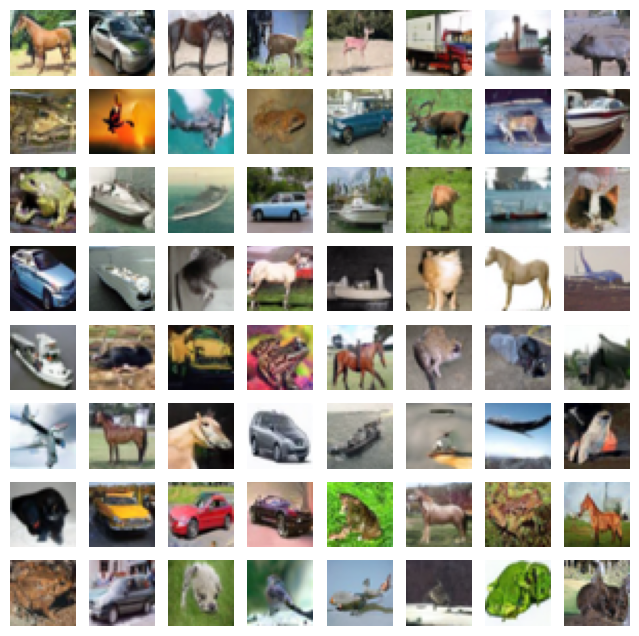

In [45]:
# Sample 64 images
x = torch.randn(64, 3, 32, 32, device=device)

t_span = torch.linspace(0, 1, 2, device=device)
with torch.no_grad():
    traj = odeint(
        model, x, t_span, rtol=tol, atol=tol, method=integration_method
    )

traj = traj[-1, :]  # .view([-1, 3, 32, 32]).clip(-1, 1)
img = (traj * 127.5 + 128).clip(0, 255).to(torch.uint8)  # .permute(1, 2, 0)

# plot the images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(img[i * 8 + j].permute(1, 2, 0).cpu().numpy())
        ax[i, j].axis("off")

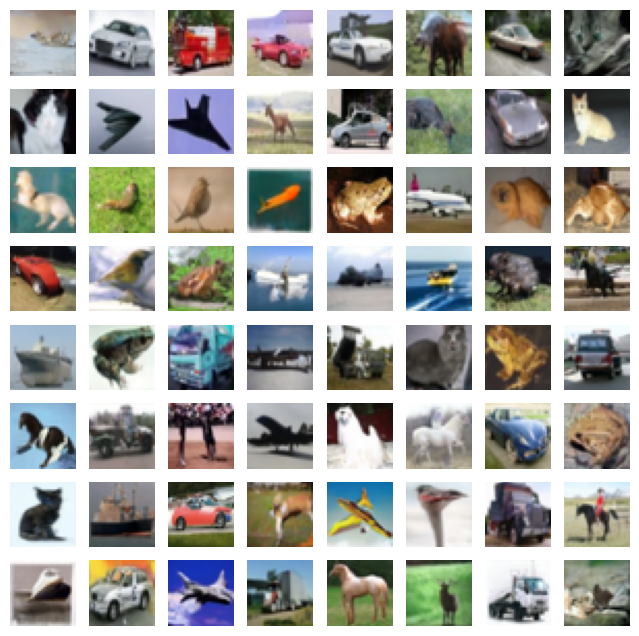

In [47]:
# Sample 64 images
x = torch.randn(64, 3, 32, 32, device=device)

t_span = torch.linspace(0, 1, 100 + 1, device=device)
with torch.no_grad():
    traj = neural_ode.trajectory(x, t_span=t_span)
traj = traj[-1, :]  # .view([-1, 3, 32, 32]).clip(-1, 1)
img = (traj * 127.5 + 128).clip(0, 255).to(torch.uint8)  # .permute(1, 2, 0)

# plot the images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(img[i * 8 + j].permute(1, 2, 0).cpu().numpy())
        ax[i, j].axis("off")

In [49]:
from cifar10_models.vgg import vgg13_bn

classifer = vgg13_bn(pretrained=True).to(device)
# models expect data to be in range [0, 1] then normalized by
mean = [0.4914, 0.4822, 0.4465]
std = [0.2471, 0.2435, 0.2616]

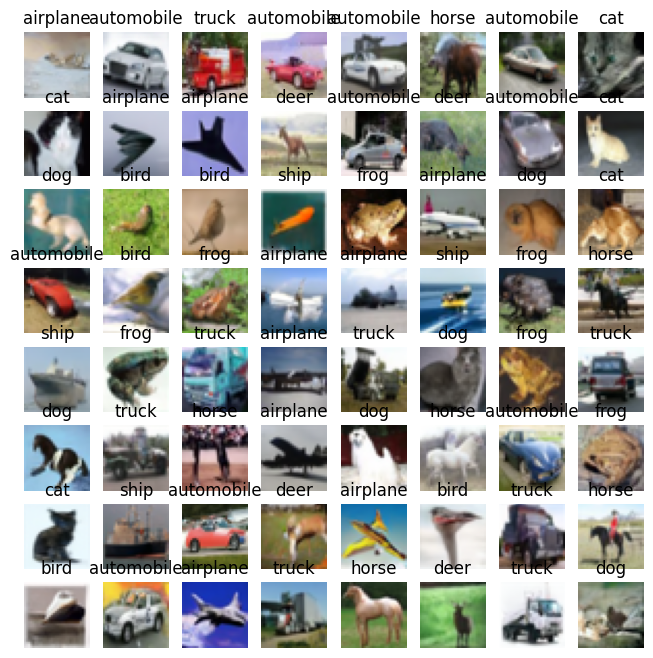

In [50]:
cifar10_labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}
# classify generated imgs
with torch.no_grad():
    logits = classifer((img.float() / 255 - torch.tensor(mean).cuda()[None, :, None, None]) / torch.tensor(std).cuda()[None, :, None, None])
    preds = torch.argmax(logits, 1)
# plot images with predicted labels (with text of class)
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(img[i * 8 + j].permute(1, 2, 0).cpu().numpy())
        ax[i, j].axis("off")
        ax[i, j].set_title(f"{cifar10_labels[preds[i * 8 + j].item()]}")